Source of data: https://data.stackexchange.com/stackoverflow/query/edit/960504  
SQL request: 
   <code>SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2016' AND Tags IS NOT NULL AND Score > 10</code>

Good ressource: 
- [machinelearningplus](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) 
- [towardsdatascience](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)
  
  

01. <a href="#1.-Import-and-cleaning-data">Import and cleaning data</a>  
    1.1 <a href="#1.1-Tag-processing">Tag processing</a>  
    1.2 <a href="#1.2-Corpus-processing">Corpus processing</a>  
    1.3 <a href="#1.3-Feature-engineering">Feature engineering</a>  
02. <a href="#2.-Unsupervised-learning">Unsupervised learning</a>  
    2.1 <a href="#2.1-LDA:-LatentDirichletAllocation">LDA: LatentDirichletAllocation</a>  
    2.2 <a href="#2.2-NMF:-Negative-Matrix-Factorisation">NMF: Negative Matrix Factorisation</a>  
03. <a href="#5.-supervised-models">supervised models</a>


## 1. Import and cleaning data
The first cleaning consist mainly on removing some specific characters (":", "*", "[", ...) and html/xml tags.
The objective of this section is to build a clean list of vocabulary words that will be used in our models.

In [2]:
# import data
import pandas as pd
import nltk   # Natural Language Toolkit

text = pd.read_csv("QueryResults.csv", index_col=0)
print("text shape:", text.shape)
text.head()

text shape: (50000, 5)


,Body,Title,Tags,LastActivityDate,Score
Id,,,,,
1986859,<p>You have a biased random number generator t...,Unbiased random number generator using a biase...,<algorithm><random><probability><clrs>,2016-04-24 21:53:59,11
22676,<p>I have a small utility that I use to downlo...,How do I download a file over HTTP using Python?,<python><http><urllib>,2019-01-02 12:02:36,720
104099,<p>Some things are easier to implement just by...,When to use Windows Workflow Foundation?,<.net><workflow><workflow-foundation>,2018-03-06 15:02:13,146
36339694,<p>I would like to replace a string indicating...,How to Increment Version Number via Gulp Task?,<javascript><angularjs><gulp><build-process>,2018-05-02 21:05:38,15
22732,<p>I am trying to do some string concatenation...,How do I pass multiple string parameters to a ...,<string><powershell><parameters><arguments>,2016-11-29 19:40:09,32


In [8]:
# to limit processing time
text_df = text.sample(10000)

# Merge Body and Title columns
corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]

In [5]:
# clean text function
import re   # Regular expression library

def cleantext(raw_text):
    """clean raw text: 
           1. remove markups
           2. remove some special characters
           3. lower all"""
    
    #1. remove markups
    cleanr = re.compile('<.*?>')  
    cleantext = re.sub(cleanr, ' ', raw_text)
    
    #2. remove special characters
    element2remove = [r"\.\s", r'"', r"'", r"\!", r"\?", r"\,",
                      r"\:", r"\(", r"\)", r"\n", r"\*", r"\]", r"\[", "&nbsp;",
                      "&lt;", "&amp", r"\//", "=", r"\{", r"\}", r"\&gt;", ";", r"\%"]                   
    for e in element2remove:
        cleantext = re.sub(e, ' ', cleantext)
        
    #3. lower all (remove Capital letters)   
    cleantext = cleantext.lower() 
    
    return cleantext

In [9]:
print("raw text -----------------------------------------------------")
print(corpora.iloc[1])
print("clean text -----------------------------------------------------")
corpora = corpora.apply(cleantext)
print(corpora.iloc[1])

raw text -----------------------------------------------------
how can I distinguish which part of UITableViewCell has been clicked<p>I have created a <code>UITableView</code> with a custom <code>UITableViewCell</code>. My cell includes one <code>UIImageView</code> on the left and <code>UITextView</code> on the right.</p>

<p>Inside <code>UITableViewController</code>, I set both image and text in tableview <code>cellForRowAtIndexPath</code>.</p>

<p>Everything shows fine but now I need to implement <code>didSelectRowAtIndex</code> and I need to distinguish if <code>UIImageView</code> or <code>UITextView</code> of the cell has been clicked.</p>

<p>Let's say, image clicking is representing delete action and the rest of the cell editing action.</p>

clean text -----------------------------------------------------
how can i distinguish which part of uitableviewcell has been clicked i have created a  uitableview  with a custom  uitableviewcell  my cell includes one  uiimageview  on the lef

### 1.1 Tag processing
In this section we will clean and explore the tag columns.

In [32]:
# clean tags
tags = text_df.loc[:, "Tags"]

def cleantags(tags):
    """clean raw tags"""
    #remove markups
    tags = tags.replace("><", ' ')
    tags = tags.replace("<", '')
    tags = tags.replace(">", '')
    tags = tags.lower()  # remove capital letters
    return tags

tags = tags.apply(cleantags)
tags.head()

Id
11782328    delphi msbuild compilation version delphi-xe2
11070874                           iphone ios uitableview
35575276                              c++ language-lawyer
62044                                     bash shell find
18910700                  android voip video-conferencing
Name: Tags, dtype: object

In [34]:
# lists of tags
all_tags = []       # list of all tags
primary_tags = []   # list of first tags (= the most relevent for each docs)
document_tags =  [] # "list of list" of tags for each document
for line in tags:
    tag = line.split()
    primary_tags.append(tag[0])
    document_tags.append(tag)
    for w in tag:
        all_tags.append(w)
        
primary_tags = nltk.FreqDist(primary_tags)   # ~ dict type
all_tags = nltk.FreqDist(all_tags)           # ~ dict type

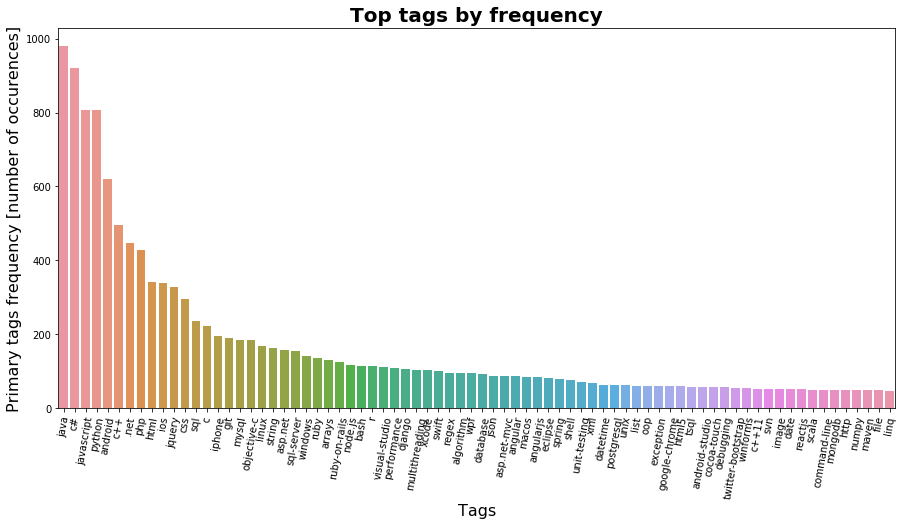

In [36]:
# most common tags plot
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

warnings.simplefilter('ignore')

# inputs
top_n = 75   # number of tag to display
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
df_2 = pd.DataFrame(primary_tags.most_common(), columns=["tags","freq_primary"])  
df = pd.merge(df_1, df_2, how="left" )

# plot
plt.figure(figsize=(15,7))
plt.title("Top tags by frequency", fontweight="bold", size=20)
sns.barplot(y= "freq_all", x= "tags", data= df.loc[0:top_n, :], label="Total")
plt.xticks(rotation=80, size=10)
plt.xlabel("Tags", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()

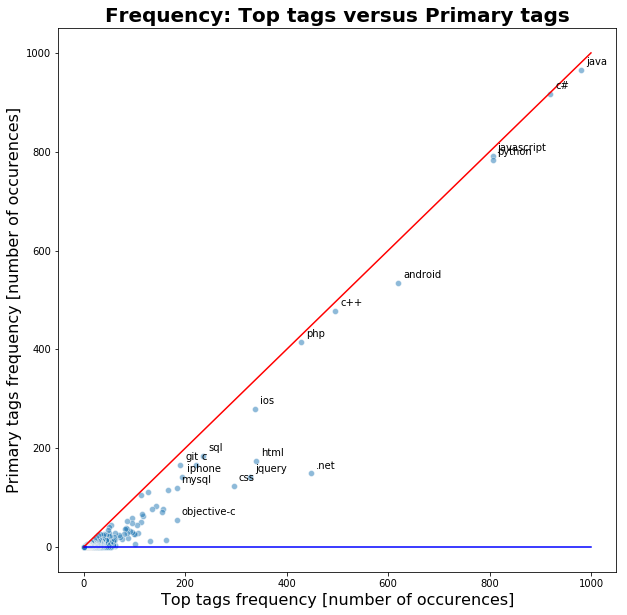

In [41]:
# Relation in-between frequency for top tags versus primary tags 
import numpy as np

# plot
plt.figure(figsize=(10, 10))
plt.title("Frequency: Top tags versus Primary tags", fontweight="bold", size = 20)
sns.scatterplot(x="freq_all", y="freq_primary", data=df, alpha=0.5)

# text annotations
for i in range(0,18):
    plt.annotate(df.loc[i,"tags"],
                 (df.loc[i,"freq_all"]+10, df.loc[i,"freq_primary"]+10),
                 size=10)

# unity line
u = np.linspace(0,1000,10)
plt.plot(u,u, c="red")
plt.plot(u,u*0, c="blue")
    
plt.xlabel("Top tags frequency [number of occurences]", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()  

Tags relatively close to the red unity line are almost always primary tags, whereas the ones close to the blue line are almost never. Most commons tags are often primary and seems to correspond of popular programming languages.
For the rest we will focus the top 150 most commons tags.

In [42]:
# creaton of top tag list
top_n = 150
top_t = list(df.loc[0:top_n-1, "tags"])

# Extra infos
count_top = df.loc[0:top_n, "freq_all"].sum()
count_all = df["freq_all"].sum()
fract_t = round(top_n/len(df),2)*100
fract_v = round(count_top/count_all,3)*100
print("The top {} tags ({}% of the tag population)\
represent {}% in term of volume/occurences.".format(top_n, fract_t, fract_v))

The top 150 tags (3.0% of the tag population)represent 50.7% in term of volume/occurences.


### 1.2 Corpus processing
In this section we clean and explore the corpus (body columns).
We will extract nouns or adjectives that are not in a stopword list.

In [43]:
# Part of Speech Tagging
import nltk
from nltk.tokenize import PunktSentenceTokenizer   # already train sentence tokensier
from nltk.corpus import stopwords
import numpy as np

# --------------------------------------------------------------------------------

# standard stopwords list from nltk library
stopwords = set(stopwords.words("english"))

# updated with some specific words found in the corpus
stopwords.update(["p","/p","way","=","something", "anyone", "possible", "good", "example",
                 "question", "solution", "able", "different", "first", 'following',
                  "anything", 'help', 'thing','sure', 'many', 'lot', 'much', "several",
                  "wrong", "right", "idea", "easy", "everything", "difference", "|",
                 "certain", "kind", "great", "nothing", "answer", "please", "little",
                 "/", r"\&gt", "+", "..", "specific", "code", "new", "name",
                 "error", "use", "file", "work", "value", "ok", "true"])

def process_content(text_body, stopwords):
    """
    Tokenize a text ('text_body') by words and keep the nouns(NN) and adjective or numeral, ordinal (JJ) 
    then remove stop words ('stopwords').
    Inputs:
        - text_body: string
        - stopwords: list of string
    Output:
        - return a list of words selection
        """
    
    tokenizer = PunktSentenceTokenizer()
    tokenized = tokenizer.tokenize(text_body)
    all_nouns = []   
    for sentence in tokenized:
        # words = nltk.word_tokenize(sentence)
        words = sentence.split()
        # get the information of the word (noune, verb,etc..)
        tagged = nltk.pos_tag(words)  
        for w in tagged:
            if ((w[1] == "NN")or(w[1] == "JJ")) and (w[0] not in stopwords):
                all_nouns.append(w[0])
    return all_nouns

In [44]:
# list of processed words
all_words = []
for body in corpora:
    tokenized_body = process_content(body, stopwords)
    for w in tokenized_body:
        all_words.append(w)
all_words = nltk.FreqDist(all_words)   # ~ dict type
print("{} words have been extracted".format(len(all_words)))

56732 words have been extracted


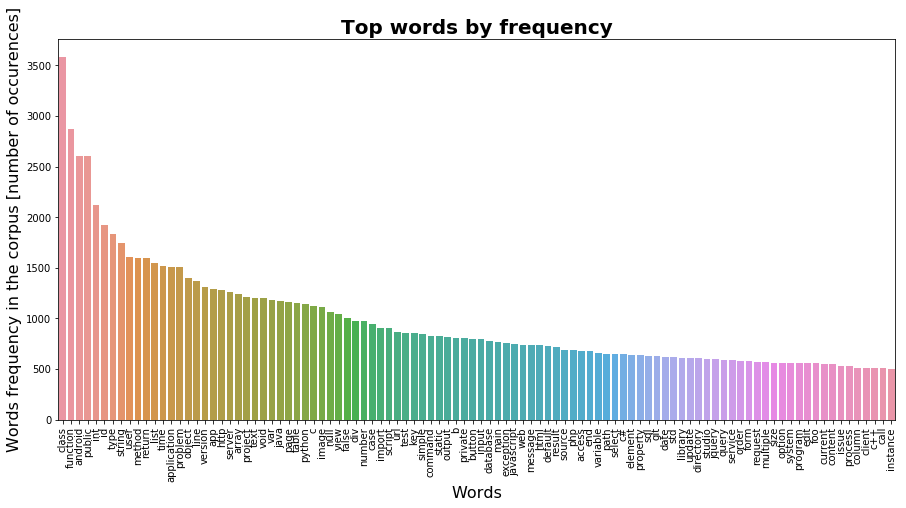

In [45]:
# most frequent words
# inputs
top_n = 100   # number of top words to display
df = pd.DataFrame(all_words.most_common(top_n), columns=["words","freq"])

# plot
plt.figure(figsize=(15,7))
plt.title("Top words by frequency", fontweight="bold", size=20)
plt.xticks(rotation=90, size=10)
sns.barplot(y="freq", x="words", data=df.loc[0:top_n, :], label="Total");
plt.xlabel("Words", size=16)
plt.ylabel("Words frequency in the corpus [number of occurences]", size=16)
plt.show()

In [47]:
# # Build vocabulary dict based on the most fequent words
# number_of_top_words = 500
# top_w = list(zip(*all_words.most_common(number_of_top_words)))[0]

# # add top tags to this list
# vocab_list = set(list(top_w) + list(top_t))
# print("Our vocabulary list 'vocab_list' has",len(vocab_list),"words.")

Our vocabulary list 'vocab_list' has 597 words.


### 1.3 Feature engineering
In this section, based on our corpus and list of most commons words, we will create new features that can be used as input for our models:
- TF Term Frequency table: for each documents (row) we will compute the frequency of the most frequent words (columns)
- TF-IDF Term Frequency - Inverse Document Frequency: The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This help to reduce the importance of the very commons words. More information [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
First, to build those tables we need to select wich feature/words that would be used as input. For this we will run several times:
    1. Create vocabulary list
    2. Create TF and TF-IDF Tables (Bag of Words)
    3. Run the LDA and NMF models
    4. score evaluation

On each loops we will change the initial vocabulary list composition, and see the impact on the final scoring.

In [52]:
# vocabulary list creation
def vocabulary(all_words, all_tags, Nw, Nt):
    """ return a dictionary of vocabulary. It merges the top Nw words from all_words
    with the top Nt from all_tags. This format is needed as input of nltk vectoriser"""
    top_w = list(zip(*all_words.most_common(Nw)))[0]
    top_t = list(zip(*all_tags.most_common(Nt)))[0]
    # add top tags to this list
    top_w = set(list(top_w) + list(top_t))

    # formating: list of for for vectorized input
    return dict(zip(top_w, range(0, len(top_w))))

In [71]:
# Functions used for the scoring evaluations
# Note: The words return here are the top X based on the number of occurence
# could be better the have the top percentage compare to the complete Corpus

def display_topics2(model, feature_names, no_top_words=25):
    """create a panda data frame of the top words present in each topics.
    inputs: 
        - model: fitted model, from where we will extract the results (numeric)
        - feature_names: list of string (words used in the model)
        - no_top_words: int, the number of top words per topics we want to extract
    output:
        - DataFrame 
        """
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict["Topic%d" % (topic_idx)] = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(word_dict).T

def topic_score(model, vectorized_input, feature_names, top_t, document_tags, limited=True):
    """The scoring function is design for the purpose off assessing the quality of the predicted tag
    in the context of tags suggestion. For tis we will compute the ratio of real tags words present
    in the predicted list of tags.
    Inputs: 
        - model: fitted sklearn model, from where we will extract the results (numeric).
        - vectorized_input: tf or tf-idf vectorized input
        - feature_names: list of string (words used in the model)
        - document_tags: list of list of str, each document has a list of real tags
        - top_t: list of str, all existing tags 
        - limited: indicate if the scoring is done on tags present in the vocabulary list (False: or all tags).
        True by default since we cannot predic tags that are not in the input vocabulary list.
    Output:
        - score: float, [0:1]
        """

    # topic df ----------------------------------------------------------------------------
    topic_df = display_topics2(model, feature_names, no_top_words=25)
    # associate each topic with a list of tags
    topics_kwords_df = (topic_df.isin(top_t)*topic_df).T
    topic2tags_d = {}
    tags_per_topic = []
    for topic in topics_kwords_df:
        tag_list = []
        for e in topics_kwords_df.loc[:, topic]:
            if e is not "":
                tag_list.append(e)
        topic2tags_d[topic] = tag_list

    # Create Document Vs Topic Matrix ------------------------------------------------------
    model_output = model.transform(vectorized_input)
    # column names
    topicnames = ["Topic" + str(i) for i in range(model.components_.shape[0])]
    # index names
    docnames = ["Post" + str(i) for i in range(vectorized_input.shape[0])]
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

    # Tag prediction -----------------------------------------------------------------------
    treshold = 0.20
    tag_pred = []
    for post in df_document_topic.index:
        tags_post = []
        mask = df_document_topic.loc[post, :] >= treshold
        topic_pred = list(df_document_topic.loc[post, mask].index)
        for topic in topic_pred:
            tags_post = tags_post + topic2tags_d[topic].copy()
        tag_pred.append(tags_post)

    # Scoring ----------------------------------------------------------------------------------
    tag_score = []   # list of score for each document (score = ratio of real tags present in the prediction)
    for i in range(len(document_tags)):
        score = 0 
        count_e = 0
        for e in document_tags[i]: 
            if ((limited==True) and (e in vocab_list)) or (limited==False):
                if e in tag_pred[i]:
                    score = score + 1
                count_e = count_e + 1    
                tag_score.append(round(score/count_e,2))

    return sum(tag_score)/len(tag_score)

In [76]:
# Manual grid seach on the composition of vocabulary

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import numpy as np

n_top_w = [1,50,100,300]
n_top_t = [100,150,200,300]

grid_score_lda_tf = pd.DataFrame(0, index = n_top_w, columns= n_top_t) 
grid_score_lda_tf.index.name = "n_top_w"
grid_score_lda_tf.columns.name = "n_top_t"
grid_score_lda_tfidf = grid_score_lda_tf.copy()
grid_score_nmf_tf = grid_score_lda_tf.copy()
grid_score_tfidf = grid_score_lda_tf.copy()
grid_score_nmt_tfidf = grid_score_lda_tf.copy()


for w in n_top_w:
    for t in n_top_t:

        voca = vocabulary(all_words, all_tags, w, t)
        # Vectorizer ------------------------------------------
        # tf
        tf_vectorizer = CountVectorizer(vocabulary=voca,
                                        stop_words=stopwords)
        tf = tf_vectorizer.fit_transform(corpora)

        # tf-idf
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(vocabulary=voca,
                                           stop_words=stopwords)
        tfidf = tfidf_vectorizer.fit_transform(corpora)

        # extraction of feature names
        feature_names = tf_vectorizer.get_feature_names()     
        
        
        # Models ------------------------------------------------
        no_topics = 25 
        # Run LDA on tf
        lda_tf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tf)
        grid_score_lda_tf.loc[w, t ] = topic_score(lda_tf, tf, feature_names, top_t)

        # Run LDA on tfidf
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tfidf)
        grid_score_lda_tfidf.loc[w, t ] = topic_score(lda_tfidf, tfidf, feature_names, top_t)
        
        # Run NMF on tf
        nmf_tf = NMF(n_components=no_topics, 
                     random_state=1, 
                     init='nndsvd').fit(tf)
        grid_score_nmf_tf.loc[w, t ] = topic_score(nmf_tf, tf, feature_names, top_t)
        
        # Run NMF on tfidf
        nmf_tfidf = NMF(n_components=no_topics, 
                        random_state=1, 
                        init='nndsvd').fit(tfidf)
        grid_score_nmt_tfidf.loc[w, t ] = topic_score(nmf_tfidf, tfidf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 1   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 50   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 100   T= 300


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 100


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 150


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 200


C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


loops W= 300   T= 300


In [79]:
grid_score_lda_tf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.281971,0.293587,0.288465,0.267990
50,0.231829,0.241924,0.250867,0.234055
100,0.202075,0.230225,0.238934,0.231737
300,0.200625,0.193501,0.201804,0.209789


In [80]:
grid_score_lda_tfidf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.274717,0.294396,0.288836,0.264009
50,0.245658,0.266458,0.266104,0.245182
100,0.232528,0.250424,0.256527,0.243066
300,0.220102,0.220815,0.226201,0.231514


In [82]:
grid_score_nmt_tfidf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.111092,0.087007,0.088413,0.067507
50,0.024171,0.032613,0.025317,0.038263
100,0.026349,0.028783,0.030452,0.031888
300,0.016221,0.021647,0.021730,0.020335


In [84]:
grid_score_nmf_tf

n_top_t,100,150,200,300
n_top_w,,,,
1,0.096497,0.101115,0.093115,0.081130
50,0.069998,0.070063,0.070374,0.061293
100,0.056009,0.057478,0.056222,0.051603
300,0.048122,0.049860,0.048501,0.047175


The best score is obtain when the vocabulary input list is a combinaison of the top 1 words and the top 150 tags. It is quite instinctive that the chance of getting a correct tags is better if from the start, we select only the tags words as feature.
import numpy as npHowever here, we might also want the futur tag recommendation engine to be able to also produce new tags (IT world is changing fast). So even if it degrade a little bit our final quality we would introduce the 50 top words from the corpus. The Best model using the standard parameters is LDA combined with Tf-idf table. Note that NMF might perform better if we tune the parameters. However for simplicity, we will keep the LDA model with tfidf and try to optimise it.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [73]:
# LDA TF-idf with previous choices
no_topics = 25
voca = vocabulary(all_words, all_tags, 50, 150)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=voca,
                                   token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]",  #  to keep c#, c++, .net, ...
                                   stop_words=None)
tfidf = tfidf_vectorizer.fit_transform(corpora)

# extraction of feature names
feature_names = tfidf_vectorizer.get_feature_names()  

# Run LDA on tfidf
lda_tfidf = LatentDirichletAllocation(n_components=no_topics, 
                                random_state=0).fit(tfidf)

# print some metrics
data_dense = tfidf.todense()   # to compute sparsity (Percentage of Non-Zero cells)
print("LDA with tfidf---------------------------------------------------------")
score = topic_score(lda_tfidf, tfidf, feature_names, top_t, document_tags)
print("Tags prediction hit rate:", round(score*100,1), "%")
sparsicity = ((data_dense > 0).sum()/data_dense.size)*100
print("Sparsicity:              ", round(sparsicity,1), "%")
print("Log Likelihood:          ", round(lda_tfidf.score(tfidf),0))
print("Perplexity:              ", round(lda_tfidf.perplexity(tfidf),0))

# top 10 words in each topics
display_topics2(lda_tfidf, feature_names, no_top_words=10)

LDA with tfidf---------------------------------------------------------
Tags prediction hit rate: 57.4 %
Sparsicity:               2.5 %
Log Likelihood:           -111015.0
Perplexity:               527.0


,0,1,2,3,4,5,6,7,8,9
Topic0,table,database,c#,mysql,api,postgresql,user,sql,id,sqlite
Topic1,list,django,simple,python,sorting,return,problem,case,method,class
Topic2,server,sql,spring,linq,security,database,table,math,user,application
Topic3,id,div,type,class,html,text,function,button,css,vb.net
Topic4,line,command,time,output,file,syntax,validation,qt,html5,text
Topic5,python,image,version,xml,file,script,problem,import,string,function
Topic6,user,button,css,rest,firebase,text,page,application,winforms,image
Topic7,file,shell,script,perl,github,command,line,problem,parsing,unicode
Topic8,php,date,import,mongodb,function,csv,file,scala,ubuntu,string
Topic9,ruby,xcode,ios,lambda,app,iphone,file,application,project,version


## 3.LDA: LatentDirichletAllocation

In [58]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
12    -170.768036   33.852322       1        1  8.842410
14      -8.297423   60.352818       2        1  4.799951
0      170.080246  -95.467003       3        1  4.758018
3       90.985764  168.023666       4        1  4.679412
23      47.546501 -199.703705       5        1  4.593547
4      188.650604   -3.231510       6        1  4.328652
7       65.732513   85.364944       7        1  4.323803
8      -58.362694 -179.015076       8        1  4.313371
21      42.242027    9.862345       9        1  4.264432
24     -52.352104  -83.710526      10        1  4.141691
15     156.918442   98.367882      11        1  4.032267
5      -57.914314  191.055984      12        1  3.801184
18     100.726753  -46.110123      13        1  3.783233
16       7.211605 -128.849243      14        1  3.734724
20    -106.969055  -32.858555      15        1  3.692902
2       11.655365  142.228012      16        1  3.666245
22     115.160255   28.012436      17        1  3.490143
6      -63.564102  108.925941      18        1  3.483140
13     -30.813780  -11.025598      19        1  3.293166
19    -184.669983  -55.517384      20        1  3.292198
11      90.706451 -125.128212      21        1  3.274200
1     -125.748695 -123.351929      22        1  3.017713
17     -87.741791   38.930653      23        1  3.013528
10    -144.129166  118.533997      24        1  2.879965
9       26.325018  -59.556911      25        1  2.500105, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
188   Default  286.000000            android  286.000000  30.0000  30.0000
95    Default  319.000000               list  319.000000  29.0000  29.0000
51    Default  295.000000               java  295.000000  28.0000  28.0000
185   Default  574.000000               file  574.000000  27.0000  27.0000
160   Default  295.000000                app  295.000000  26.0000  26.0000
140   Default  288.000000             python  288.000000  25.0000  25.0000
77    Default  171.000000                git  171.000000  24.0000  24.0000
94    Default  256.000000            project  256.000000  23.0000  23.0000
122   Default  260.000000             object  260.000000  22.0000  22.0000
19    Default  240.000000                  c  240.000000  21.0000  21.0000
43    Default  208.000000              array  208.000000  20.0000  20.0000
87    Default  262.000000             server  262.000000  19.0000  19.0000
128   Default  158.000000             jquery  158.000000  18.0000  18.0000
98    Default  190.000000               html  190.000000  17.0000  17.0000
54    Default  429.000000             string  429.000000  16.0000  16.0000
80    Default  194.000000         javascript  194.000000  15.0000  15.0000
6     Default  188.000000              image  188.000000  14.0000  14.0000
182   Default  194.000000               test  194.000000  13.0000  13.0000
29    Default  175.000000                url  175.000000  12.0000  12.0000
16    Default  194.000000              table  194.000000  11.0000  11.0000
20    Default  165.000000                php  165.000000  10.0000  10.0000
143   Default  155.000000                sql  155.000000   9.0000   9.0000
31    Default  302.000000               user  302.000000   8.0000   8.0000
129   Default  153.000000                div  153.000000   7.0000   7.0000
134   Default  394.000000              class  394.000000   6.0000   6.0000
37    Default  106.000000               ruby  106.000000   5.0000   5.0000
13    Default  193.000000               view  193.000000   4.0000   4.0000
179   Default  177.000000            windows  177.000000   3.0000   3.0000
83    Default  148.000000             button  148.000000   2.0000   2.0000
38    Default  138.000000                  b  138.000000   1.0000   1.0000
...       ...     

Topics are well clusterised with very similar size. But we can see that some topics are stil merge as Java and xml, Ubuntu and dokers.

In [103]:
# Manual Grid search, using our "tag hit rate" as scoring metric.

# values to test
topic_word_p = [0, 0.1, 0.25]  # for topic_word_prior parameter
doc_topic_p = [0, 0.1, 0.25]   # for doc_topic_prior parameter

# scoring empty dataFrame
grid_score = pd.DataFrame(0, index = topic_word_p, columns= doc_topic_p) 
grid_score.index.name = "topic_word_prior"
grid_score.columns.name = "doc_topic_prior"

# run the scoring calculation
for a in topic_word_p:
    for l1 in doc_topic_p:
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                    topic_word_prior=a,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=l1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:681: RuntimeWarning: invalid value encountered in double_scalars
  score += np.sum(gammaln(prior * size) - gammaln(np.sum(distr, 1)))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWar

In [104]:
grid_score

doc_topic_prior,0.0,0.1,0.25
topic_word_prior,,,
0.00,0.281760,0.201726,0.016777
0.10,0.278556,0.208160,0.015744
0.25,0.279211,0.211822,0.014206


In [106]:
# Let's run on n_components and learning_decay
n_components = [20, 25, 30] 
learning_decay = [0.5, 0.7, 0.9]

grid_score = pd.DataFrame(0, index = n_components, columns= learning_decay) 
grid_score.index.name = "n_components"
grid_score.columns.name = "learning_decay"

for a in n_components:
    for l1 in learning_decay:
        lda_tfidf = LatentDirichletAllocation(n_components=a,
                                        learning_decay=l1,
                                        topic_word_prior=0.0,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                        doc_topic_prior=0.0,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                        max_iter=50, 
                                        learning_method='online', 
                                        learning_offset=50.,
                                        random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:679: RuntimeWarning: invalid value encountered in multiply
  score = np.sum((prior - distr) * dirichlet_distr)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:680: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(distr) - gammaln(prior))
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:681: RuntimeWarning: invalid value encountered in double_scalars
  score += np.sum(gammaln(prior * size) - gammaln(np.sum(distr, 1)))


In [107]:
grid_score

learning_decay,0.5,0.7,0.9
n_components,,,
20,0.274796,0.281214,0.273697
25,0.282306,0.281760,0.281556
30,0.281239,0.281670,0.276941


In [110]:
# Final Model

lda_tfidf = LatentDirichletAllocation(n_components=25,
                                    learning_decay=0.5,
                                    topic_word_prior=0.1,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=0.1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)

In [111]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

C:\Users\ben\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0       29.442093  -74.715141       1        1  6.779561
3       19.003693   98.158394       2        1  5.479803
9      108.896309  -50.432259       3        1  5.256125
16    -127.626152  -15.185468       4        1  5.202128
2     -101.463112   34.860767       5        1  4.785882
19      -3.602908   16.265209       6        1  4.602897
15      61.146866  -40.097832       7        1  4.563405
7      -25.431633 -143.910858       8        1  4.503370
14    -107.624870  -67.964088       9        1  4.364906
21      29.039188   47.422489      10        1  4.070787
20     -51.672684   25.632126      11        1  3.915048
1       53.091106    7.718464      12        1  3.915000
6      102.762558    5.693677      13        1  3.883929
18      18.770805  -21.745804      14        1  3.796031
5      -19.339237  -95.528183      15        1  3.730453
10     -56.499191  -61.211792      16        1  3.714754
8       -9.972327  -52.963757      17        1  3.522956
22      78.090065   59.083492      18        1  3.425045
24     -66.653343   80.436874      19        1  3.395172
11     -19.586102   63.213531      20        1  3.226965
17      76.375000  -96.894043      21        1  2.932769
12     -77.940239  -17.545507      22        1  2.872338
23     -73.490440 -111.154823      23        1  2.841437
4      -32.717228  -16.965618      24        1  2.806302
13      28.900101 -125.608551      25        1  2.412938, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
162   Default  413.000000           test  413.000000  30.0000  30.0000
53    Default  294.000000          array  294.000000  29.0000  29.0000
94    Default  270.000000           null  270.000000  28.0000  28.0000
186   Default  238.000000            css  238.000000  27.0000  27.0000
118   Default  283.000000            app  283.000000  26.0000  26.0000
172   Default  303.000000    application  303.000000  25.0000  25.0000
14    Default  280.000000           text  280.000000  24.0000  24.0000
0     Default  224.000000            php  224.000000  23.0000  23.0000
178   Default  281.000000           http  281.000000  22.0000  22.0000
92    Default  357.000000         string  357.000000  21.0000  21.0000
58    Default  226.000000          table  226.000000  20.0000  20.0000
170   Default  213.000000            key  213.000000  19.0000  19.0000
143   Default  236.000000         python  236.000000  18.0000  18.0000
11    Default  275.000000             id  275.000000  17.0000  17.0000
62    Default  267.000000           list  267.000000  16.0000  16.0000
15    Default  200.000000            url  200.000000  15.0000  15.0000
35    Default  270.000000           java  270.000000  14.0000  14.0000
51    Default  194.000000      exception  194.000000  13.0000  13.0000
78    Default  336.000000          class  336.000000  12.0000  12.0000
87    Default  202.000000         static  202.000000  11.0000  11.0000
184   Default  188.000000            api  188.000000  10.0000  10.0000
61    Default  275.000000         server  275.000000   9.0000   9.0000
47    Default  161.000000     powershell  161.000000   8.0000   8.0000
80    Default  444.000000           file  444.000000   7.0000   7.0000
70    Default  336.000000       function  336.000000   6.0000   6.0000
43    Default  218.000000           page  218.000000   5.0000   5.0000
161   Default  215.000000        android  215.000000   4.0000   4.0000
56    Default  166.000000      variables  166.000000   3.0000   3.0000
101   Default  176.000000          image  176.000000   2.0000   2.0000
44    Default  169.000000          input  169.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
54    Topic25    0.474514   apache-spark    3.163259   1.8273  -6.8260
77  

## 5. supervised models
In this section we will used the Tags information on 4 supervised classification models:
- LinearSVC
- Random Forest
- NaiveBase Gaussian  
- Logistic Regression


Since we can have more than one tags per documents, we need to handle a multilabels classification.   
Tags will be [One hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) in a DataFrame "Y".  
The labels input format would be a dataframe where each columns correspond to a tag, each row to a document. Value would be "1" if the tag is present for this document and "0" otherwise. 
We will continue to use the same words and tag list used for the unserpervised learning.


In [64]:
def raw2XY(text_df, tags_list, vocab_list):
    """format inputs to be ready to be use in sklearn models
    input X, y"""    

    # Y
    tag_vectorizer = CountVectorizer(vocabulary=tags_list,
                                token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")  #  to keep c#, c++, .net, ...
    Y = tag_vectorizer.fit_transform(text_df.loc[:, "Tags"].apply(cleantags))
    Y = pd.DataFrame(Y.A, columns=tag_vectorizer.get_feature_names())
      
    # X
    corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]
    corpus_vectorizer = CountVectorizer(vocabulary=vocab_list,
                                        token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")  #  to keep c#, c++, .net, ...
    X = corpus_vectorizer.fit_transform(corpora.apply(cleantext))
    X = pd.DataFrame(X.A, columns=corpus_vectorizer.get_feature_names())
    
    return X, Y

In [68]:
# top_w = list(zip(*all_words.most_common(500)))[0]
# top_t = list(zip(*all_tagss.most_common(150)))[0]
# vocab = set(list(top_w) + list(top_t))

X_test, Y_test = raw2XY(text_df, tags_list=top_t, vocab_list=vocab_list)
X_train, Y_train = raw2XY(text.sample(10000), tags_list=top_t, vocab_list=vocab_list)

In [69]:
print("X_test.shape:",X_test.shape)
print("Y_test.shape:",Y_test.shape)
print("X_train.shape:",X_train.shape)
print("Y_train.shape:",Y_train.shape)

X_test.shape: (10000, 597)
Y_test.shape: (10000, 150)
X_train.shape: (10000, 597)
Y_train.shape: (10000, 150)


In [129]:
# test different classifier with Multioutput 
# Note: unless random Forest all with standard parameters 

from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# rf
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=50)).fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)

# GaussianNB
gaussNB = MultiOutputClassifier(GaussianNB()).fit(X_train, Y_train)
Y_pred_gauss = gaussNB.predict(X_test)

# SVC
svc = MultiOutputClassifier(LinearSVC()).fit(X_train, Y_train)
Y_pred_svc = svc.predict(X_test)

# Logistic regression
logi_reg = MultiOutputClassifier(LogisticRegression()).fit(X_train, Y_train)
Y_pred_logi_reg = logi_reg.predict(X_test)

In [285]:
logi_reg.score(X_test, Y_test)

0.343

In [287]:
rf.score(X_test, Y_test)

0.4229

In [310]:
proba_rf = rf.predict_proba(X_test)

In [318]:
pd.DataFrame(Y_pred_rf[:,1])

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,1
9,0


In [315]:
pd.DataFrame(proba_rf[1])

,0,1
0,1.00,0.00
1,1.00,0.00
2,1.00,0.00
3,1.00,0.00
4,1.00,0.00
5,1.00,0.00
6,0.96,0.04
7,1.00,0.00
8,0.42,0.58
9,1.00,0.00


In [288]:
gaussNB.score(X_test, Y_test)

0.0256

In [319]:
proba_Gauss = gaussNB.predict_proba(X_test)

In [ ]:
pd.DataFrame(proba_Gauss[1])

In [289]:
svc.score(X_test, Y_test)

0.3169

In [291]:
rf = RandomForestClassifier(n_estimators=50).fit(X_train, Y_train)
Y_pred_rf2 = rf.predict(X_test)

In [292]:
rf.score(X_test, Y_test)

0.4375

In [308]:
Y_pred_rf2[11]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [253]:
# results DataFrame
results = pd.DataFrame(Y_test.sum(), 
                       index=Y_test.sum().index, 
                       columns=["occurence_test"])

# Hit Rate
results["Rf_hit_rate"] = (Y_pred_rf*Y_test).sum()/Y_test.sum(axis=0)
results["Gauss_hit_rate"] = (Y_pred_gauss*Y_test).sum()/Y_test.sum(axis=0)
results["svc_hit_rate"] = (Y_pred_svc*Y_test).sum()/Y_test.sum(axis=0)
results["logiReg_hit_rate"] = (Y_pred_logi_reg*Y_test).sum()/Y_test.sum(axis=0)
results["occurence_train"] = Y_train.sum()
results["range"] = results["occurence_train"].apply(lambda x : int(round(x/25,0)*25))

In [294]:
(Y_pred_rf2.sum(axis=1)).mean()

0.8131

In [273]:
(Y_pred_rf.sum(axis=1)).mean()

0.7894

In [296]:
# F1-score
from sklearn.metrics import f1_score
f1_score(Y_test, Y_pred_rf2, average="weighted")

0.5828185539500055

In [240]:
i=1
a = (results["Rf_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()
print("{:30} {:30}%".format(titles[i]+":", round(a*100,2)))

Gaussian Naive Bayes:          45.42%


Hit rate per model:
-------------------
Random Forest:            45.4%
Gaussian Naive Bayes:     67.8%
Support Vector Machine:   53.1%
Logistic regression:      48.1%


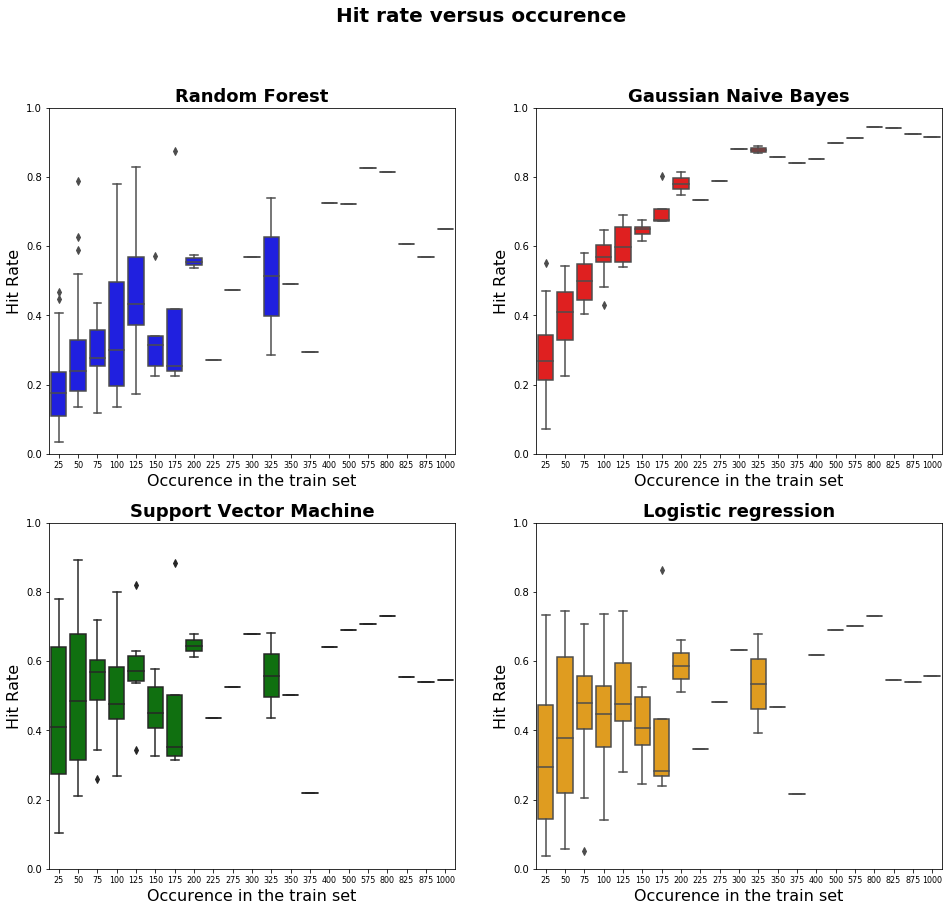

In [254]:
import seaborn as sns

col_label = ["Rf_hit_rate", "Gauss_hit_rate", "svc_hit_rate", "logiReg_hit_rate"]
colors = ["blue", "red", "green", "orange"]
titles = ["Random Forest", "Gaussian Naive Bayes", "Support Vector Machine", "Logistic regression"]

print("Hit rate per model:")
print("-------------------")
for i,m in enumerate(col_label):
    a = (results[m]*results["occurence_test"]).sum()/results["occurence_test"].sum()
    print("{:25} {:3.1f}%".format(titles[i]+":", a*100))

fig = plt.figure(figsize=(16,14))
fig.suptitle("Hit rate versus occurence", fontweight="bold", size=20)
for i,m in enumerate(col_label):
    plt.subplot(2,2,i+1) 
    sns.boxplot(x="range",
                y=m,
                data=results,
                color=colors[i])
    plt.title(titles[i],fontweight="bold", size=18)
    plt.ylim(0,1)
    plt.ylabel("Hit Rate", size=16)
    plt.xlabel("Occurence in the train set", size=16)
    plt.xticks(fontsize=8, rotation=0)
plt.show()

Without parameter's tuning the Gaussian Naive Bayes is the model that give the best hit rate on tags. In the graph we can also see that its hit rate seems to continualy increase with the number of tags occurences in the train data set. tag with more than 200 occurene in the training reach a hit rate of at least 80%.

In [256]:
Y_

,occurence_test,Rf_hit_rate,Gauss_hit_rate,svc_hit_rate,logiReg_hit_rate,occurence_train,range
java,981,0.649337,0.916412,0.544343,0.556575,992,1000
c#,920,0.569565,0.923913,0.539130,0.540217,879,875
javascript,806,0.606700,0.942928,0.554591,0.544665,820,825
python,806,0.813896,0.944169,0.730769,0.729529,802,800
android,620,0.825806,0.912903,0.708065,0.703226,575,575


In [138]:
(results["Rf_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

0.4542145967375057

In [139]:
(results["Gauss_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

0.6781698836680314

In [140]:
(results["svc_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

0.5310976798596218

In [141]:
(results["logiReg_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

0.4810554364073569

In [355]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC = OneVsRestClassifier(LinearSVC(), n_jobs=-1)

categories = list(Y_test.columns)
accuracy_score_d = {}
f1_score_d = {}
Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
for category in categories:
    # train
    SVC.fit(X_train, Y_train[category])
    
    # compute the testing accuracy
    Y_pred[category] = SVC.predict(X_test)
    accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
    f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])

In [353]:
Y_test.index

RangeIndex(start=0, stop=10000, step=1)

In [356]:
accuracy_score_d

{'java': 0.9432,
 'c#': 0.939,
 'javascript': 0.9459,
 'python': 0.9689,
 'android': 0.9786,
 'c++': 0.9734,
 'php': 0.9777,
 '.net': 0.9574,
 'html': 0.9659,
 'ios': 0.9706,
 'jquery': 0.9789,
 'css': 0.9801,
 'sql': 0.9781,
 'c': 0.9748,
 'mysql': 0.9867,
 'objective-c': 0.9783,
 'git': 0.9931,
 'iphone': 0.9792,
 'sql-server': 0.984,
 'asp.net': 0.979,
 'ruby': 0.9884,
 'string': 0.9798,
 'arrays': 0.9823,
 'linux': 0.9837,
 'visual-studio': 0.985,
 'django': 0.9942,
 'ruby-on-rails': 0.9808,
 'windows': 0.9826,
 'bash': 0.9903,
 'r': 0.9886,
 'node.js': 0.9877,
 'algorithm': 0.9899,
 'performance': 0.9834,
 'wpf': 0.9938,
 'xcode': 0.9897,
 'swift': 0.9911,
 'asp.net-mvc': 0.9887,
 'eclipse': 0.9936,
 'database': 0.9863,
 'multithreading': 0.9901,
 'angularjs': 0.9925,
 'angular': 0.9924,
 'macos': 0.99,
 'regex': 0.9928,
 'postgresql': 0.9948,
 'json': 0.9915,
 'spring': 0.9919,
 'unit-testing': 0.9913,
 'c++11': 0.9936,
 'svn': 0.997,
 'xml': 0.9921,
 'reactjs': 0.9925,
 'file': 

In [340]:
f1_score_d

{'java': 0.6505875077303649,
 'c#': 0.6192259675405744,
 'javascript': 0.6290097629009763,
 'python': 0.7920529801324503,
 'android': 0.8211586901763224,
 'c++': 0.706140350877193,
 'php': 0.6782608695652175,
 '.net': 0.3203883495145631,
 'html': 0.4612954186413902,
 'ios': 0.5099337748344371,
 'jquery': 0.6568627450980392,
 'css': 0.6598290598290598,
 'sql': 0.5338983050847459,
 'c': 0.48016701461377864,
 'mysql': 0.6127167630057804,
 'objective-c': 0.3710144927536232,
 'git': 0.8130081300813008,
 'iphone': 0.4178272980501393,
 'sql-server': 0.5360230547550433,
 'asp.net': 0.44504021447721176,
 'ruby': 0.5671641791044777,
 'string': 0.3682539682539682,
 'arrays': 0.4567901234567901,
 'linux': 0.46511627906976744,
 'visual-studio': 0.3868312757201647,
 'django': 0.7819548872180452,
 'ruby-on-rails': 0.36721311475409835,
 'windows': 0.3458646616541353,
 'bash': 0.5488372093023255,
 'r': 0.5789473684210527,
 'node.js': 0.47457627118644063,
 'algorithm': 0.48484848484848486,
 'performance

In [357]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
round(f1_score_tot, 3)

0.546

In [104]:
Y_pred.sum(axis=0)

array([713, 647, 597, 663, 493, 418, 187, 319, 210, 229, 289, 238, 201,
       129, 100, 172, 138, 107, 114,  82,  97, 126,  91, 110, 115,  72,
        95,  72,  63, 102,  56,  87,  34,  86,  83,  51,  62,  82,  51,
        68,  67,  73,  54,  62,  70,  60,  50,  47,  60,  27,  30,  17,
        29,  22,  26,  44,  38,  17,  40,  14,  26,  46,  21,  45,  41,
        27,  15,  28,  28,  35,  30,  47,  39,  40,  21,  43,  37,  35,
        19,  34,  37,  34,  16,  17,  17,  15,  22,  29,  25,  28,  17,
        10,  21,  23,  23,  29,  22,  18,  24,  25,  28,  18,  17,   7,
        29,  20,  11,  10,  18,  15,  15,  12,  13,  19,  18,  24,  21,
        27,   9,  20,  28,  22,  25,  10,   8,  32,  34,  11,  30,  21,
         8,  11,  32,  21,  19,   8,  18,  16,   9,  17,  13,  19,  22,
        18,  18,  20,  16,  20,  11,   8], dtype=int64)

In [121]:
Y_test.sum().index

Index(['java', 'c#', 'javascript', 'python', 'android', 'c++', '.net', 'php',
       'html', 'ios',
       ...
       'memory', 'haskell', 'visual-studio-2010', 'csv', 'colors',
       'asp.net-web-api', 'forms', 'unicode', 'data-structures', 'winapi'],
      dtype='object', length=150)

In [255]:
### Random Forest
#### TEST form https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff ###
# using binary relevance

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(RandomForestClassifier(n_estimators=50))
# train
classifier.fit(X_train, Y_train)
# predict
Y_pred = classifier.predict(X_test)
# tag hit rate
tag_hit_rate = (Y_test*Y_pred.A).sum().sum()/Y_test.sum().sum()
print("tag hit rate: ", round(tag_hit_rate*100,1), "%")

tag hit rate:  45.3 %


In [ ]:
results["logiReg_hit_rate"] = (Y_pred_logi_reg*Y_test).sum()/Y_test.sum(axis=0)

In [95]:
### GaussianNB Using sklearn MultiOutputClassifier
#### TEST form https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff ###
# using binary relevance

# from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = MultiOutputClassifier(GaussianNB())
# train
classifier.fit(X_train, Y_train)
# predict
Y_pred = classifier.predict(X_test)
# tag hit rate
tag_hit_rate = (Y_test*Y_pred).sum().sum()/Y_pred.sum().sum()
print("tag hit rate: ", round(tag_hit_rate*100,1), "%")

tag hit rate:  6.3 %


In [96]:
### GaussianNB Using sklearn MultiOutputClassifier
#### TEST form https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff ###
# using binary relevance
# from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression


# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = MultiOutputClassifier(LogisticRegression())
# train
classifier.fit(X_train, Y_train)
# predict
Y_pred = classifier.predict(X_test)
# tag hit rate
tag_hit_rate = (Y_test*Y_pred).sum().sum()/Y_pred.sum().sum()
print("tag hit rate: ", round(tag_hit_rate*100,1), "%")

tag hit rate:  70.5 %


In [85]:
(Y_test*predictions.A).sum().sum()/predictions.A.sum().sum()

0.543271469433912

In [74]:
####################################### TEST ###########################################

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def multilabel_model_fit(model, X_train, Y_train, X_test, Y_test):
    """run a model with a multilabel Y (matrix)
    Inputs:
        - model: an instance of a classification model
        - X_train, X_test: regular array
        - Y_train, Y_test: one hot encoded array, where each col is a label
    Outputs:
        - Y_pred: predicted one hot encoded array, where each col is a label
        - """
    categories = list(Y_test.columns)
    accuracy_score_d = {}
    f1_score_d = {}
    Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
    model_multi = {}
    for category in categories:
        # train
        model_multi[category] = model.fit(X_train, Y_train[category])

        # compute the testing accuracy
        Y_pred[category] = model.predict(X_test)
        accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
        f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])

    f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
    f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
    print("Overall f1_score:", round(f1_score_tot, 3))
    print("Tag hit rate:", round((Y_pred*Y_test).sum().sum()/Y_pred.sum().sum(), 3))    
    
def multilabel_model_pred(model, X):
    
    
def multilabel_scores(Y_pred, Y_test):    

IndentationError: expected an indented block (<ipython-input-74-be3e43efc094>, line 38)

In [ ]:
####################################### TEST ###########################################

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = KNeighborsClassifier()

categories = list(Y_test.columns)
accuracy_score_d = {}
f1_score_d = {}
Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
for category in categories:
    # train
    model.fit(X_train, Y_train[category])
    
    # compute the testing accuracy
    Y_pred[category] = model.predict(X_test)
    accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
    f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])
    
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
print("Overall f1_score:", round(f1_score_tot, 3))
print("Tag hit rate:", round((Y_pred*Y_test).sum().sum()/Y_pred.sum().sum(), 3))  

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [368]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
round(f1_score_tot, 3)

0.547

In [369]:
(Y_pred*Y_test).sum().sum()/Y_pred.sum().sum()

0.5410968087959238

In [91]:
doc_num = 10

mask = Y_test.iloc[doc_num] == 1
print("doc number: ", doc_num, "----------------------------" )
print(X_test.iloc[doc_num])
print("")
print("Real tags from raw : ", tags.iloc[doc_num])
print("Real tags from test_y : ", list(Y_test.iloc[doc_num][mask].index))
print("Prediction tags : ", prediction_list[doc_num])
print("")


doc number:  10 ----------------------------
$this-                 0
.net                   0
/div                   0
/groupid               0
/version               0
access                 0
account                0
action                 0
activity               0
actual                 0
add                    0
additional             0
address                0
advance                0
ajax                   0
alert                  0
algorithm              0
amazon-web-services    0
android                0
android-layout         0
android-studio         0
angular                0
angularjs              0
apache                 0
api                    0
app                    0
apple                  0
application            0
approach               0
args                   0
                      ..
vector                 0
version                0
version-control        0
video                  0
view                   0
vim                    0
virtual                0
visib

NameError: name 'prediction_list' is not defined